In [1]:
import meshio
import pygalmesh
import pygmsh
import numpy as np
import copy
import glob
#from mshr import *
#from dolfin import *
from collections import Counter
import matplotlib.pyplot as plt
import os
import json
import shutil
import scipy.optimize as opt
from EnergyMinimization import *

# Initialisation

User settings: What are the continuum parameters we want? In 2D, we know that the elastic modulii are proportional to the microscopic spring constant. We also know that the continuum and microscopic momdulii are related by a lattice space: $\mu = O(1) k$, $k_c = k_d a$. Since I dont know any better, for know I will just set k to mu.

In [2]:
# Target mesh size:
target_a = 0.2
# continuum bending modulus:
kc=0.5
# continuum shear modulus:
mu=1
# Energetic penalty for volume change
B=100000
# The Material Nonlinearity parameter, between 0 and 1
MatNon=0.99
# the spring prestress values 
g0start=1.75
g0end=3
g0step=0.2

# The microscopic values
kbend=kc/target_a
khook = mu
theta0=0.2

Setting up the experiment:

In [3]:
# root folder for data
DataFolder=os.getcwd()+'/Data/'
# Folder for the run data
#RunFolder="kc_"+"{0:0.1f}".format(kc)+"_B_"+"{0:0.1f}".format(B)+"/"
RunFolder="Scratch/"
# Name of the run
RunName=""
# Name of the current file
ScriptName="EnergyMinimizationScript3D.ipynb"

In [4]:
path = DataFolder+RunFolder
# make the folder 
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)
    
# try and clear out the folder of vtk files and log files, if there was a previous run in it
for filename in glob.glob(path+'*.vtk')+glob.glob(path+'*.log'):
    file_path = os.path.join(path, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))
                
#Dump all the parameters to a file in the run folder        
f=open(DataFolder+RunFolder+"Parameters.log","w+")
datadict= { 
        "a":target_a,
        "kc":kc, 
        "B":B,
        "mu":mu,
        "g0start":g0start,
        "g0end":g0end,
        "alpha": MatNon
}
json.dump(datadict,f)
f.close()

# and for good measure, dump a copy of this code into the data file too
shutil.copyfile(ScriptName,DataFolder+RunFolder+ScriptName)

Creation of the directory /home/jackbinysh/Code/ActiveElastocapillarity/Python/EnergyMinimization/Data/Scratch/ failed


'/home/jackbinysh/Code/ActiveElastocapillarity/Python/EnergyMinimization/Data/Scratch/EnergyMinimizationScript3D.ipynb'

# Making the Mesh

Make the mesh, write it out to the folder. I am going to use the gmsh mesh

In [5]:
#todo: put in target a
with pygmsh.occ.Geometry() as geom:
    geom.characteristic_length_max = target_a
    ellipsoid = geom.add_ball([0.0, 0.0, 0.0], 1)
    #ellipsoid = geom.add_ellipsoid([0.0, 0.0, 0.0], [0.95, 0.95, 1.05])

    InputMesh = geom.generate_mesh()

OutputMesh = copy.deepcopy(InputMesh)    
InputMesh.write(DataFolder+RunFolder+RunName+"InputMesh.vtk") 

/home/jackbinysh/miniconda3/lib/python3.8/site-packages/numpy/ctypeslib.py:521: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return array(obj, copy=False)


In [6]:
#InputMesh=MakeDolfinMesh3D(0.2, 100)
#OutputMesh = copy.deepcopy(InputMesh)    
#InputMesh.write(DataFolder+RunFolder+RunName+"InputMesh.vtk") 

Make the bond lists, make the oriented boundary triangles list, make the mapping from bonds to boundary triangles

In [7]:
interiorbonds,edgebonds,boundarytris, bidxTotidx, tetras= MakeMeshData3D(InputMesh)
bonds=np.concatenate((interiorbonds,edgebonds))
orientedboundarytris=OrientTriangles(InputMesh.points,boundarytris,np.array([0,0,0]))
boundarytris=orientedboundarytris

Check out the Mesh. One of the lessons learnt is that you shouldnt have much of a spread in the intial edge lengths

0.24813027099951912

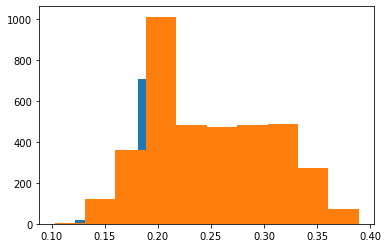

In [8]:
edgelengths= MakeBondHist(InputMesh.points,edgebonds)
np.mean(edgelengths)
edgelengths= MakeBondHist(InputMesh.points,bonds)
np.mean(edgelengths)

# Energy Minimization

In [9]:
def mycallback(xi):
    
    counter=len(history)
    tempP = xi.reshape((-1, 3))
    history.append(counter)
    
    
    print("iteration:"+"{0:0.1f}".format(counter))   
    #print(Volume3D_tetras(tempP,tetras)[607])
    #print((B*(Volume3D_tetras(tempP,tetras)-TargetVolumes)**2)[607])
    
    #VolumeConstraintEnergy = (B*(Volume3D_tetras(tempP,tetras)-TargetVolumes)**2).sum()
    #print(VolumeConstraintEnergy)  
    #history.append(Volume3D_tetras(tempP,tetras))
    
    # stuff to screen
    #print("iteration:"+"{0:0.1f}".format(counter)+"Total Area:" + "{0:0.2f}".format(vTotalArea(tempP,triangles)))
   
    #print (B*(Volume3D_tetras(tempP,tetras)-TargetVolume)**2)

    #output for visualisation
    OutputMesh.points = tempP           
    OutputMesh.write(DataFolder+RunFolder+RunName+"TempOutput"+"Output"+"{0:0.2f}".format(g0)+"_"+str(counter)+".vtk",binary=True)

In [10]:
# make the preferred rest lengths of the interior springs
interiorpairs=InputMesh.points[interiorbonds]
interiorvecs = np.subtract(interiorpairs[:,0,:],interiorpairs[:,1,:])
InteriorBondRestLengths=np.linalg.norm(interiorvecs,axis=1)

# make the preferred rest lengths of the edge springs. Initially have the at g0=1, but then
#update them in the loop
edgepairs=InputMesh.points[edgebonds]
edgevecs = np.subtract(edgepairs[:,0,:],edgepairs[:,1,:])
InitialEdgeBondRestLengths=np.linalg.norm(edgevecs,axis=1)

# The volume constraint is simply that the target volume should be the initial volume
TargetVolumes=Volume3D_tetras(InputMesh.points,tetras)

# initial input points. Pout changes over time
Pout_ij =InputMesh.points

## apply a shear
#lamz=1.2
#lamx=1/np.sqrt(lamz)
#lamy=1/np.sqrt(lamz)
#Pout_ij[:,2]=lamz*Pout_ij[:,2]
#Pout_ij[:,0]=lamx*Pout_ij[:,0]
#Pout_ij[:,1]=lamy*Pout_ij[:,1]


for g0 in np.arange(g0start,g0end,g0step):
    
    print("Current g0"+"{0:0.2f}".format(g0))
    
    # the important bit! Giving it the prestress
    EdgeBondRestLengths= g0*InitialEdgeBondRestLengths
    r0_ij=np.concatenate((InteriorBondRestLengths,EdgeBondRestLengths))
    

    # minimize
    history=[]
    #energy3D(P,bondlist,orientedboundarytris,bidxTotidx,tetras,r0_ij,khook,kbend,theta0,B,MatNon,TargetVolumes): 
    Pout_ij = opt.minimize(energy3D, Pout_ij.ravel()
                            ,callback=mycallback
                            ,options={'gtol':1e-02,'disp': True}  
                            ,args=(bonds
                                  ,orientedboundarytris
                                  ,bidxTotidx
                                  ,tetras
                                  ,r0_ij
                                  ,khook
                                  ,kbend
                                  ,theta0
                                  ,B
                                  ,MatNon
                                  ,TargetVolumes)
                           ).x.reshape((-1, 3))
   
    # stuff to screen
    print("Total Volume tris is:" + "{0:0.2f}".format(Volume3D(Pout_ij,orientedboundarytris,bidxTotidx)))
    print("Total Volume tetras is:" + "{0:0.2f}".format(Volume3D_tetras(Pout_ij,tetras).sum()))

    # write the output 
    OutputMesh.points= Pout_ij  
    OutputMesh.write(DataFolder+RunFolder+RunName+"g0_"+"{0:0.2f}".format(g0)+".vtk",binary=True)  


Current g01.75
iteration:0.0
iteration:1.0
iteration:2.0
iteration:3.0
iteration:4.0
iteration:5.0
iteration:6.0
iteration:7.0
iteration:8.0
iteration:9.0
iteration:10.0
iteration:11.0
iteration:12.0
iteration:13.0
iteration:14.0
iteration:15.0
iteration:16.0
iteration:17.0
iteration:18.0
iteration:19.0
iteration:20.0
iteration:21.0
iteration:22.0
iteration:23.0
iteration:24.0
iteration:25.0
iteration:26.0
iteration:27.0
iteration:28.0
iteration:29.0
iteration:30.0
iteration:31.0
iteration:32.0
iteration:33.0
iteration:34.0
iteration:35.0
iteration:36.0
iteration:37.0
iteration:38.0
iteration:39.0
iteration:40.0
iteration:41.0
iteration:42.0
iteration:43.0
iteration:44.0
iteration:45.0
iteration:46.0
iteration:47.0
iteration:48.0
iteration:49.0
iteration:50.0
iteration:51.0
iteration:52.0
iteration:53.0
iteration:54.0
iteration:55.0
iteration:56.0
iteration:57.0
iteration:58.0
iteration:59.0
iteration:60.0
iteration:61.0
iteration:62.0
iteration:63.0
iteration:64.0
iteration:65.0
itera

iteration:201.0
iteration:202.0
iteration:203.0
iteration:204.0
iteration:205.0
iteration:206.0
iteration:207.0
iteration:208.0
iteration:209.0
iteration:210.0
iteration:211.0
iteration:212.0
iteration:213.0
iteration:214.0
iteration:215.0
iteration:216.0
iteration:217.0
iteration:218.0
iteration:219.0
iteration:220.0
iteration:221.0
iteration:222.0
iteration:223.0
iteration:224.0
iteration:225.0
iteration:226.0
iteration:227.0
iteration:228.0
iteration:229.0
iteration:230.0
iteration:231.0
iteration:232.0
iteration:233.0
iteration:234.0
iteration:235.0
iteration:236.0
iteration:237.0
iteration:238.0
iteration:239.0
iteration:240.0
iteration:241.0
iteration:242.0
iteration:243.0
iteration:244.0
iteration:245.0
iteration:246.0
iteration:247.0
iteration:248.0
iteration:249.0
iteration:250.0
iteration:251.0
iteration:252.0
iteration:253.0
iteration:254.0
iteration:255.0
iteration:256.0
iteration:257.0
iteration:258.0
iteration:259.0
iteration:260.0
iteration:261.0
iteration:262.0
iteratio

iteration:714.0
iteration:715.0
iteration:716.0
iteration:717.0
iteration:718.0
iteration:719.0
iteration:720.0
iteration:721.0
iteration:722.0
iteration:723.0
iteration:724.0
iteration:725.0
iteration:726.0
iteration:727.0
iteration:728.0
iteration:729.0
iteration:730.0
iteration:731.0
iteration:732.0
iteration:733.0
iteration:734.0
iteration:735.0
iteration:736.0
iteration:737.0
iteration:738.0
iteration:739.0
iteration:740.0
iteration:741.0
iteration:742.0
iteration:743.0
iteration:744.0
iteration:745.0
iteration:746.0
iteration:747.0
iteration:748.0
iteration:749.0
iteration:750.0
iteration:751.0
iteration:752.0
iteration:753.0
iteration:754.0
iteration:755.0
iteration:756.0
iteration:757.0
iteration:758.0
iteration:759.0
iteration:760.0
iteration:761.0
iteration:762.0
iteration:763.0
iteration:764.0
iteration:765.0
iteration:766.0
iteration:767.0
iteration:768.0
iteration:769.0
iteration:770.0
iteration:771.0
iteration:772.0
iteration:773.0
iteration:774.0
iteration:775.0
iteratio

iteration:114.0
iteration:115.0
iteration:116.0
iteration:117.0
iteration:118.0
iteration:119.0
iteration:120.0
iteration:121.0
iteration:122.0
iteration:123.0
iteration:124.0
iteration:125.0
iteration:126.0
iteration:127.0
iteration:128.0
iteration:129.0
iteration:130.0
iteration:131.0
iteration:132.0
iteration:133.0
iteration:134.0
iteration:135.0
iteration:136.0
iteration:137.0
iteration:138.0
iteration:139.0
iteration:140.0
iteration:141.0
iteration:142.0
iteration:143.0
iteration:144.0
iteration:145.0
iteration:146.0
iteration:147.0
iteration:148.0
iteration:149.0
iteration:150.0
iteration:151.0
iteration:152.0
iteration:153.0
iteration:154.0
iteration:155.0
iteration:156.0
iteration:157.0
iteration:158.0
iteration:159.0
iteration:160.0
iteration:161.0
iteration:162.0
iteration:163.0
iteration:164.0
iteration:165.0
iteration:166.0
iteration:167.0
iteration:168.0
iteration:169.0
iteration:170.0
iteration:171.0
iteration:172.0
iteration:173.0
iteration:174.0
iteration:175.0
iteratio

FileNotFoundError: [Errno 2] No such file or directory: '/home/jackbinysh/Code/ActiveElastocapillarity/Python/EnergyMinimization/Data/Scratch/TempOutputOutput2.15_342.vtk'

In [11]:
Pout_ij

array([[ 0.24331712, -0.07575039,  0.76270239],
       [-0.36736369,  0.0653855 , -0.79322079],
       [-0.10302793,  0.08710584, -0.73683171],
       ...,
       [-1.23772225, -0.1796752 , -0.6135961 ],
       [ 0.43132735,  0.0798421 , -0.22582976],
       [-0.13817909, -0.21362308, -0.53060317]])